In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

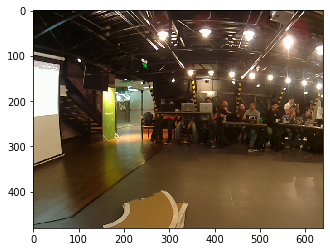

In [6]:
img = plt.imread('image.png')
plt.imshow(img)

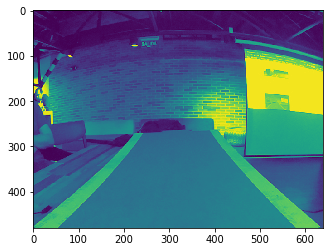

In [15]:
url = "http://10.42.0.1:8080/stream/video.jpeg"
cap = cv2.VideoCapture(url)
ret, frame = cap.read()
if ret:
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plt.imshow(rgb)
    #plt.imshow(frame)
    cv2.imwrite('image.jpeg',frame)
cap.release()

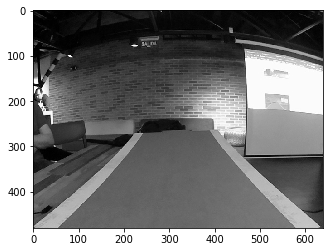

In [22]:
img = cv2.imread('image.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

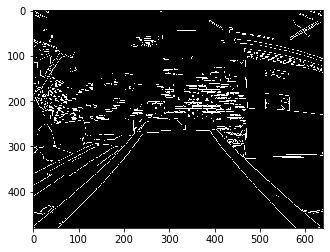

In [32]:
low_threshold = 80
high_threshold = 150

edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

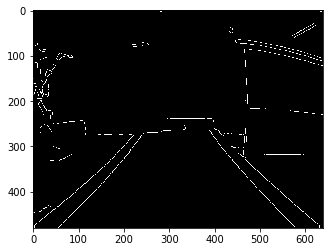

In [62]:
low_threshold = 80
high_threshold = 150

blur = cv2.GaussianBlur(gray, (11, 11), 0)

canny = cv2.Canny(blur, low_threshold, high_threshold)
plt.imshow(canny, cmap='gray')

In [63]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [55]:
h, w = gray.shape
gray.shape

(480, 640)

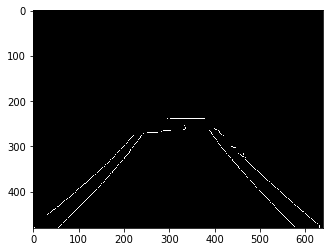

In [64]:
left_bottom = [0, h]
right_bottom = [w, h]
apex = [w//2, h//2 - 60]
area = np.array( [[left_bottom, right_bottom, apex]], dtype=np.int32 )
region = region_of_interest(canny, area)
plt.imshow(region, cmap='gray')

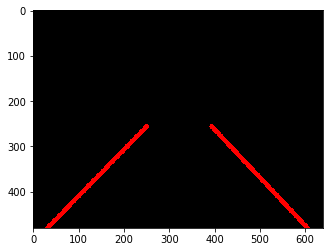

In [67]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    left_side_x = []
    left_side_y = []
    right_side_x = []
    right_side_y = []
    slp = 0.4

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > slp:
                left_side_x.extend((x1,x2))
                left_side_y.extend((y1,y2))
            if slope < -slp: 
                right_side_x.extend((x1,x2))
                right_side_y.extend((y1,y2))
         
    height = []
    height.extend((img.shape[0],min(left_side_y+right_side_y)))
    
    left_slp = np.polyfit(left_side_y,left_side_x,1)
    right_slp = np.polyfit(right_side_y,right_side_x,1)
    
    leftV = np.poly1d(left_slp)
    rightV = np.poly1d(right_slp)
    
    left_x1 = int(leftV(height[0]))
    left_x2 = int(leftV(height[1]))
    right_x1 = int(rightV(height[0]))
    right_x2 = int(rightV(height[1]))

    cv2.line(img,(left_x1,height[0]),(left_x2,height[1]),color,thickness)
    cv2.line(img,(right_x1,height[0]),(right_x2,height[1]),color,thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 15 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
img_lines = hough_lines(region, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(img_lines, cmap='gray')

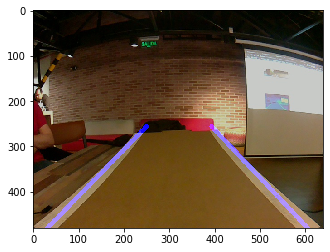

In [71]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

result = weighted_img(img_lines, img)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))